In [9]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import itertools
from statsmodels.tsa.arima.model import ARIMA
import os
import string
import warnings
import datetime
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [10]:
ct_emissions = pd.read_excel('../../../data/raw/Public GHG data 1990-2021.xlsx', sheet_name="Emission Totals")

# Extract the row corresponding to "Commercial"
row = ct_emissions[ct_emissions['Sector Emissions (MMTCO2e)'] == 'Agriculture']

# Extract the columns from 1990 to 2021 estimate
columns_of_interest = [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
                      1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
                      2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
                      2017, 2018, 2019, 2020, '2021 (ESTIMATE)']

data = row[columns_of_interest]

# Define new name for the last column
new_last_column_name = '2021'

# Rename the last column
data.rename(columns={data.columns[-1]: new_last_column_name}, inplace=True)

data

C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_23164\3279485556.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={data.columns[-1]: new_last_column_name}, inplace=True)


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0.375261,0.348502,0.389088,0.415,0.408122,0.400748,0.344938,0.348057,0.37538,0.3748,...,0.331997,0.337981,0.286675,0.311864,0.339883,0.341291,0.350344,0.369979,0.346028,0.35


In [11]:
#import the fertilizer land area data
agri_emissions = pd.read_csv('../../../results/sectors/agriculture-emissions-including-fertilizer-ratio.csv')

agri_emissions

,Unnamed: 0,MSA,Manure fertilizer land area (acres),Organic fertilizer land area (acres),Synthetic fertilizer land area (acres),Manure fertilizer,Organic fertilizer,Synthetic fertilizer,Manure fertilizer emissions (MMTCO2e),Organic fertilizer emissions (MMTCO2e),Synthetic fertilizer emissions (MMTCO2e),GHG Emissions (MMTCO2e),organic fertilizer ratio,Manure fertilizer ratio,Synthetic fertilizer ratio
0,0,New Haven Area,1125.000000,173.000000,3764.000000,10.378229,11.809963,3472.324723,0.000087,0.000099,0.029055,0.029241,0.000290,0.000254,0.085134
1,1,Hartford Area,8441.180671,604.473081,21949.928738,76.263838,40.413284,19831.180812,0.000652,0.000345,0.169438,0.170435,0.000991,0.001870,0.486219
2,2,Bridgeport Area,297.002729,193.876781,1849.048239,2.656827,12.833948,1654.059041,0.000023,0.000111,0.014273,0.014407,0.000315,0.000065,0.040554


In [12]:
total_fertilizer_ratio = agri_emissions.iloc[:, -3:].sum(axis=1)
# Multiply each value in each row by 1, 2, and 3, and create new rows
multipliers = total_fertilizer_ratio
multiplied_df = pd.concat([data * multiplier for multiplier in multipliers], ignore_index=True)

In [13]:
multiplied_df 
data=multiplied_df.T

# Define new column names
new_column_names = ['New Haven (MMTCO2e)', 'Hartford (MMTCO2e)', 'Bridgeport (MMTCO2e)']

# Assign new column names to the DataFrame
data.columns = new_column_names

data.index.name = 'year'


data.index = pd.to_datetime(data.index, format='%Y')
data.index.freq = 'AS'
df=data
#df.to_csv('../../../data/tidy/agriculture-emissions-paper.csv')
df

C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_23164\1234650506.py:14: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  data.index.freq = 'AS'


,New Haven (MMTCO2e),Hartford (MMTCO2e),Bridgeport (MMTCO2e)
year,,,
1990-01-01,0.032152,0.183533,0.015361
1991-01-01,0.029859,0.170445,0.014266
1992-01-01,0.033336,0.190295,0.015927
1993-01-01,0.035556,0.202968,0.016988
1994-01-01,0.034967,0.199604,0.016706
1995-01-01,0.034335,0.195998,0.016404
1996-01-01,0.029554,0.168702,0.014120
1997-01-01,0.029821,0.170227,0.014247
1998-01-01,0.032162,0.183591,0.015366


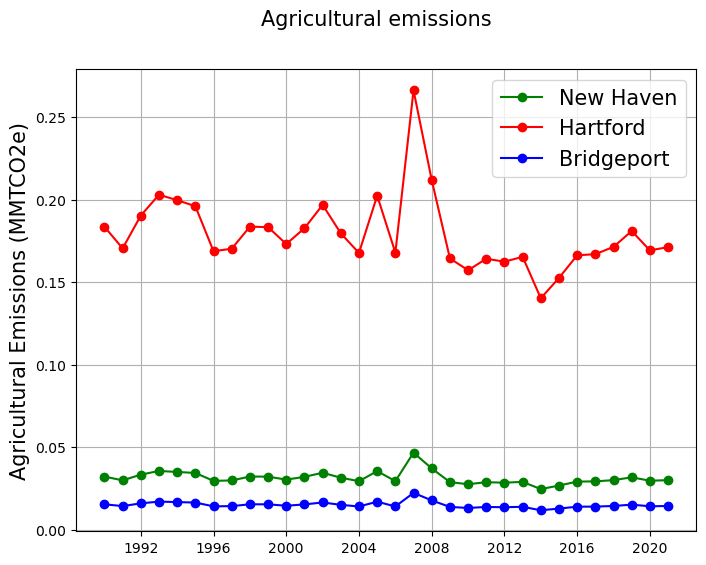

In [14]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('Agricultural emissions',fontsize=15)
actual, = plt.plot(df.index, df['New Haven (MMTCO2e)'], 'go-', label='New Haven')
actual, = plt.plot(df.index, df['Hartford (MMTCO2e)'], 'ro-', label='Hartford')
actual, = plt.plot(df.index, df['Bridgeport (MMTCO2e)'], 'bo-', label='Bridgeport')
#plt.xlabel('Year',fontsize=18)
plt.ylabel('Agricultural Emissions (MMTCO2e)',fontsize=15)
#plt.xticks(np.arange(min(electr_residential.index), max(electr_residential.index)+1, 1)) 
plt.legend(fontsize=15)
plt.grid()
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.savefig('../../../figures/agricultural-emissions-historical-change.png', dpi=600, bbox_inches='tight')

In [15]:
split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()

df_train.index.freq = 'AS'
df_test.index.freq = 'AS'

C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_23164\3239487518.py:5: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df_train.index.freq = 'AS'
C:\Users\peiyaozhao\AppData\Local\Temp\ipykernel_23164\3239487518.py:6: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df_test.index.freq = 'AS'


In [16]:
len(df_train)

26

In [17]:
len(df_test)

6

In [18]:
HEM_data = df['Hartford (MMTCO2e)']
NHM_data = df['New Haven (MMTCO2e)']
BSN_data = df['Bridgeport (MMTCO2e)']


warnings.filterwarnings("ignore")

def performance_metric(test, forecast):#observed and predicted
    """
    Evaluate forecast using different metrics.
    """
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return mape, mae, rmse

def arima_prediction(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Generate predictions for the test set
    pred = res.get_prediction(start=len(train), end=len(train) + len(test) - 1)
    pred_mean = pred.predicted_mean
    
    # Evaluate forecast
    mape, mae, rmse = performance_metric(test, pred_mean)
    
    # Calculate BIC and AIC
    bic = res.bic
    #aic = res.aic
    
    return mape, mae, rmse, bic

def gridsearch(data): 

    # Initialize list to store results
    results_list_cv = []

    p_values = range(0,7)
    d_values = range(1,3)
    q_values = range(0,7)

    # Loop through each combination of p, d, q values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mape_cv = []
                mae_cv = []
                rmse_cv = []
                bic_cv = []
            

                split_index = round(len(data)*0.8)
                train = data.iloc[:split_index].copy()
                test = data.iloc[split_index:].copy()

                mape, mae, rmse, bic = arima_prediction(train, test, order)
                mape_cv.append(mape)
                mae_cv.append(mae)
                rmse_cv.append(rmse)
                bic_cv.append(bic)
                    #aic_cv.append(aic)
                    


                # Calculate the mean of metrics across folds
                mape_mean = np.mean(mape_cv)
                mae_mean = np.mean(mae_cv)
                rmse_mean = np.mean(rmse_cv)
                bic_mean = np.mean(bic_cv)
                #aic_mean = np.mean(aic_cv)

                # Store results
                results_list_cv.append({'p': p, 'd': d, 'q': q, 'MAPE': mape_mean, 'MAE': mae_mean, 'RMSE': rmse_mean, 'BIC':bic_mean})

    # Convert list of dictionaries to DataFrame
    results_df = pd.DataFrame(results_list_cv)
    return results_df


            
# Convert list of dictionaries to DataFrame
results_df_HEM_cv=gridsearch(HEM_data)
results_df_NHM_cv=gridsearch(NHM_data)
results_df_BSN_cv=gridsearch(BSN_data)

print(results_df_HEM_cv)

    p  d  q          MAPE           MAE          RMSE         BIC
0   0  1  0  1.072115e+01  1.844996e-02  1.907909e-02  -98.249196
1   0  1  1  7.747183e+00  1.336917e-02  1.422481e-02  -96.404276
2   0  1  2  2.825890e+00  4.953544e-03  6.770125e-03  -88.868720
3   0  1  3  1.903367e+00  3.302857e-03  4.125073e-03  -80.679234
4   0  1  4  2.258196e+00  3.891150e-03  4.410899e-03  -72.699659
.. .. .. ..           ...           ...           ...         ...
93  6  2  2  1.468048e+01  2.525736e-02  2.633868e-02  -50.326996
94  6  2  3  1.701892e+13  2.913022e+10  7.081856e+10  129.256099
95  6  2  4  1.312114e+01  2.269517e-02  2.579581e-02  -45.030302
96  6  2  5  9.179152e+00  1.599498e-02  2.048244e-02  -35.115041
97  6  2  6  1.035617e+01  1.796872e-02  2.198812e-02  -36.455379

[98 rows x 7 columns]


In [19]:
test_HEM =results_df_HEM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_HEM=test_HEM.sort_values(by='RMSE').iloc[:92,:]
HEM = sorted_HEM.applymap(lambda x: f'{x:.3f}')
HEM

MAPE    MAE   RMSE      BIC
p d q                               
0 1 3   1.903  0.003  0.004  -80.679
1 1 1   1.969  0.003  0.004  -94.063
    3   1.739  0.003  0.004  -77.646
0 1 4   2.258  0.004  0.004  -72.700
2 1 2   1.590  0.003  0.004  -82.936
...       ...    ...    ...      ...
4 2 6  23.303  0.040  0.041  642.112
5 2 2  23.622  0.041  0.042  -57.727
4 2 5  24.306  0.042  0.044  -46.091
2 1 6  24.800  0.042  0.046  -33.433
1 1 6  30.537  0.052  0.058  -35.354

[92 rows x 4 columns]

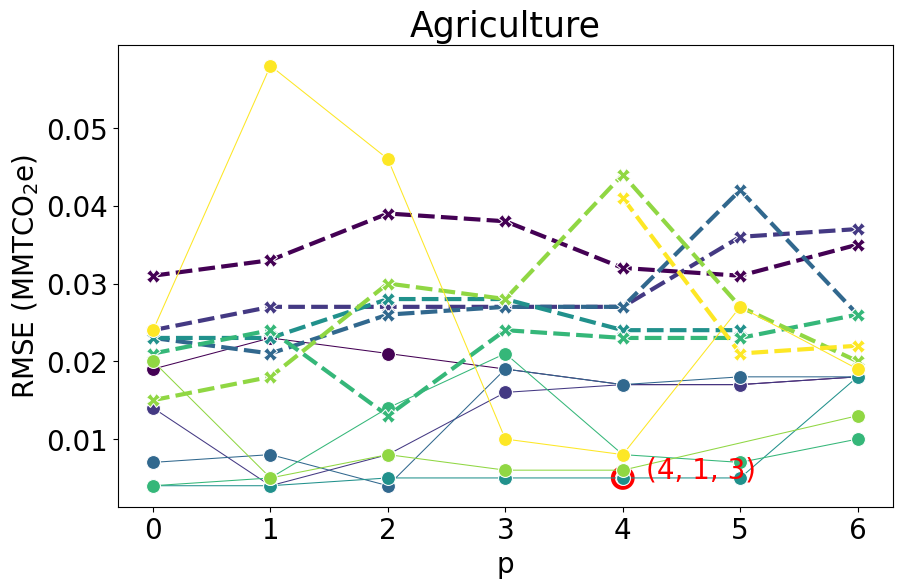

In [20]:
import seaborn as sns

HEM['RMSE'] = pd.to_numeric(HEM['RMSE'], errors='coerce')

# Check for non-numeric values in 'RMSE' column
non_numeric_values = HEM['RMSE'][HEM['RMSE'].apply(lambda x: not np.issubdtype(type(x), np.number))]
plt.figure(figsize=(10, 6))

# Using seaborn scatterplot to plot data with different sizes and colors for d and q
sns.lineplot(
    data=HEM,
    x='p', 
    y='RMSE', 
    size='d', 
    hue='q', 
    palette='viridis', 
    markers=True,
    style='d',
    legend=False,
    markersize=10
)

# Adding labels and title
plt.title('Agriculture',fontsize =25)
plt.xlabel('p',fontsize=20)
plt.ylabel('RMSE (MMTCO$_2$e)',fontsize=20)

plt.xticks(range(8), fontsize=20)

# # Customize the y-ticks
y_ticks = np.arange(0, 40, 5)  # Create y-ticks with a step of 0.5
plt.yticks(ticks=y_ticks, fontsize=20)  # Set y-ticks and their fontsize

maximum = HEM['RMSE'].max()
y_ticks = np.arange(0, maximum, 0.01)  # Create y-ticks with a step of 0.02
plt.yticks(ticks=y_ticks, fontsize=20)  # Set y-ticks and their fontsize

highlight = HEM.loc[4, 1, 3]
p, d, q = 4, 1, 3  # The index values for annotation
plt.scatter(p, highlight['RMSE'], facecolors='none', edgecolors='red', s=200, linewidth=3)
plt.text(p + 0.2, highlight['RMSE'], f'({p}, {d}, {q})', fontsize=20, color='red')

plt.savefig('../../../figures/rmse-plot/agriculture_emissions_HEM.jpg', dpi=600, bbox_inches='tight')

In [21]:
test_NHM =results_df_NHM_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_NHM=test_NHM.sort_values(by='RMSE').iloc[:92,:]
NHM = sorted_NHM.applymap(lambda x: f'{x:.3f}')
NHM

MAPE    MAE   RMSE       BIC
p d q                                 
1 1 4    2.111  0.001  0.001  -139.389
0 1 4    2.053  0.001  0.001  -142.374
1 1 1    1.966  0.001  0.001  -174.191
2 1 5    2.251  0.001  0.001  -125.894
    4    2.558  0.001  0.001  -137.094
...        ...    ...    ...       ...
5 2 5   27.849  0.008  0.012   -76.636
4 2 5   41.897  0.013  0.014   -82.177
3 2 5   50.152  0.015  0.021   -76.152
    6  133.767  0.040  0.046   710.826
5 2 4  162.979  0.049  0.077   -66.058

[92 rows x 4 columns]

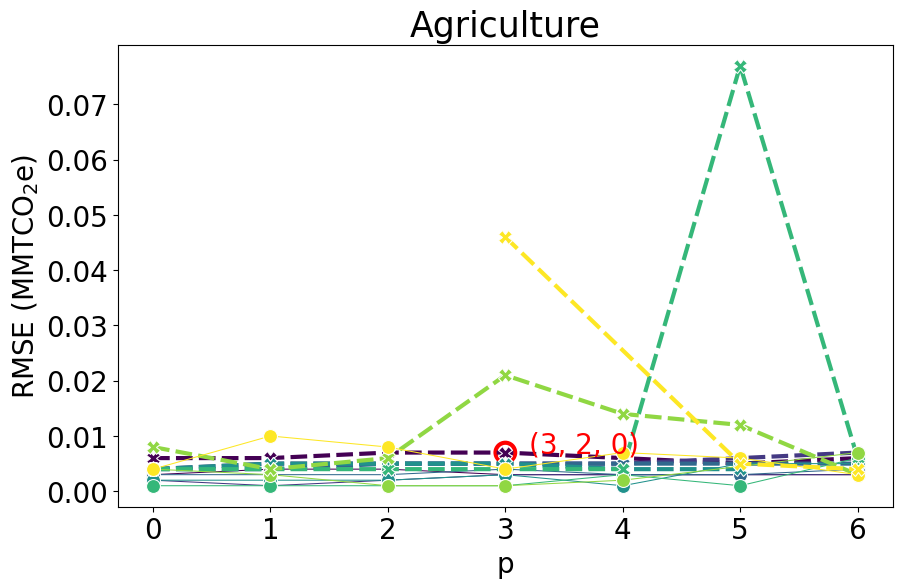

In [22]:
import seaborn as sns

NHM['RMSE'] = pd.to_numeric(NHM['RMSE'], errors='coerce')

# Check for non-numeric values in 'RMSE' column
non_numeric_values = NHM['RMSE'][NHM['RMSE'].apply(lambda x: not np.issubdtype(type(x), np.number))]
plt.figure(figsize=(10, 6))

# Using seaborn scatterplot to plot data with different sizes and colors for d and q
sns.lineplot(
    data=NHM,
    x='p', 
    y='RMSE', 
    size='d', 
    hue='q', 
    palette='viridis', 
    markers=True,
    style='d',
    legend=False,
    markersize=10
)

# Adding labels and title
plt.title('Agriculture',fontsize =25)
plt.xlabel('p',fontsize=20)
plt.ylabel('RMSE (MMTCO$_2$e)',fontsize=20)

plt.xticks(range(8), fontsize=20)

# # Customize the y-ticks
y_ticks = np.arange(0, 40, 5)  # Create y-ticks with a step of 0.5
plt.yticks(ticks=y_ticks, fontsize=20)  # Set y-ticks and their fontsize

maximum = NHM['RMSE'].max()
y_ticks = np.arange(0, maximum, 0.01)  # Create y-ticks with a step of 0.02
plt.yticks(ticks=y_ticks, fontsize=20)  # Set y-ticks and their fontsize

highlight = NHM.loc[3, 2, 0]
p, d, q = 3, 2, 0  # The index values for annotation
plt.scatter(p, highlight['RMSE'], facecolors='none', edgecolors='red', s=200, linewidth=3)
plt.text(p + 0.2, highlight['RMSE'], f'({p}, {d}, {q})', fontsize=20, color='red')

plt.savefig('../../../figures/rmse-plot/agriculture_emissions_NHM.jpg', dpi=600, bbox_inches='tight')

In [23]:
test_BSN =results_df_BSN_cv.set_index(['p','d','q'])#.loc[:,'RMSE'].idxmin()
sorted_BSN = test_BSN.sort_values(by='RMSE').iloc[:92,:]
BSN = sorted_BSN.applymap(lambda x: f'{x:.3f}')
BSN

,,,MAPE,MAE,RMSE,BIC
p,d,q,,,,
1,1,1,1.959,0.000,0.000,-208.169
0,1,2,2.635,0.000,0.001,-198.001
1,1,4,3.506,0.001,0.001,-165.527
2,1,1,4.608,0.001,0.001,-204.024
0,1,3,4.852,0.001,0.001,-184.670
...,...,...,...,...,...,...
2,2,6,174.345,0.025,0.029,713.878
5,2,4,162.985,0.023,0.037,-94.124
4,1,3,292.983,0.042,0.063,-120.920


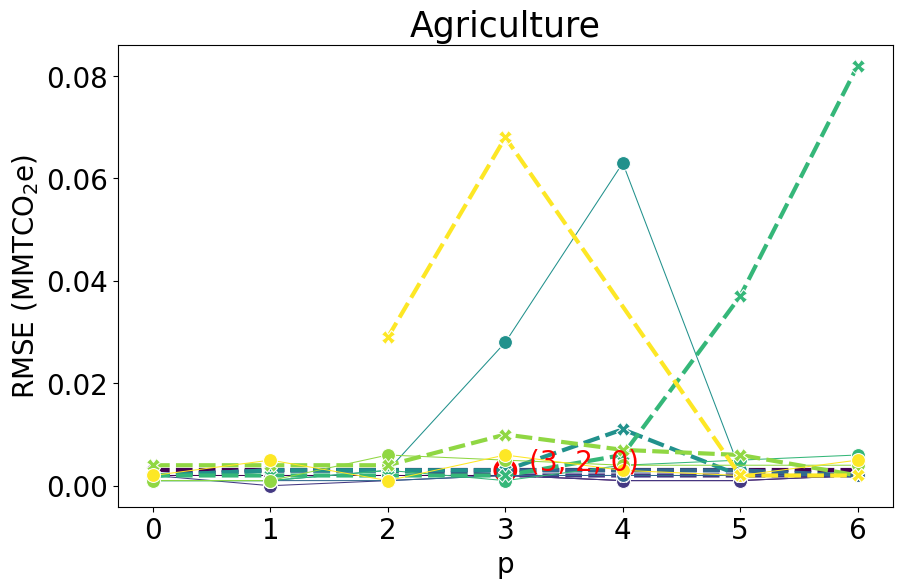

In [24]:
import seaborn as sns

BSN['RMSE'] = pd.to_numeric(BSN['RMSE'], errors='coerce')

# Check for non-numeric values in 'RMSE' column
non_numeric_values = BSN['RMSE'][BSN['RMSE'].apply(lambda x: not np.issubdtype(type(x), np.number))]
plt.figure(figsize=(10, 6))

# Using seaborn scatterplot to plot data with different sizes and colors for d and q
sns.lineplot(
    data=BSN,
    x='p', 
    y='RMSE', 
    size='d', 
    hue='q', 
    palette='viridis', 
    markers=True,
    style='d',
    legend=False,
    markersize=10
)

# Adding labels and title
plt.title('Agriculture',fontsize =25)
plt.xlabel('p',fontsize=20)
plt.ylabel('RMSE (MMTCO$_2$e)',fontsize=20)

plt.xticks(range(8), fontsize=20)

# # Customize the y-ticks
y_ticks = np.arange(0, 40, 5)  # Create y-ticks with a step of 0.5
plt.yticks(ticks=y_ticks, fontsize=20)  # Set y-ticks and their fontsize

maximum = BSN['RMSE'].max()
y_ticks = np.arange(0, maximum, 0.02)  # Create y-ticks with a step of 0.02
plt.yticks(ticks=y_ticks, fontsize=20)  # Set y-ticks and their fontsize

highlight = BSN.loc[3, 2, 0]
p, d, q = 3, 2, 0  # The index values for annotation
plt.scatter(p, highlight['RMSE'], facecolors='none', edgecolors='red', s=200, linewidth=3)
plt.text(p + 0.2, highlight['RMSE'], f'({p}, {d}, {q})', fontsize=20, color='red')

plt.savefig('../../../figures/rmse-plot/agriculture_emissions_BSN.jpg', dpi=600, bbox_inches='tight')

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Hartford (MMTCO2e)   No. Observations:                   32
Model:                 ARIMA(4, 1, 3)   Log Likelihood                  63.677
Date:                Mon, 01 Jul 2024   AIC                           -111.353
Time:                        13:56:38   BIC                           -100.986
Sample:                    01-01-1990   HQIC                          -108.271
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3547      0.500     -0.710      0.478      -1.334       0.625
ar.L2         -0.7579      0.497     -1.526      0.127      -1.732       0.216
ar.L3         -0.0615      0.425     -0.145      0.885      -0.894       0.771
ar.L4         -0.2513      0.266     -0.946      0.344      -0.772       0.269
ma.L1         -0.1322      0.711     -0.186      0.852      -1.525       1.261
ma.L2          0.7982      1.036      0.770      0.441      -1.233       2.830
ma.L3         -0.8220      0.733     -1.122      0.262      -2.258       0.614
sigma2         0.0003      0.000      0.711      0.477      -0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                33.86
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             1.69
Prob(H) (two-sided):                  0.64   Kurtosis:                         7.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

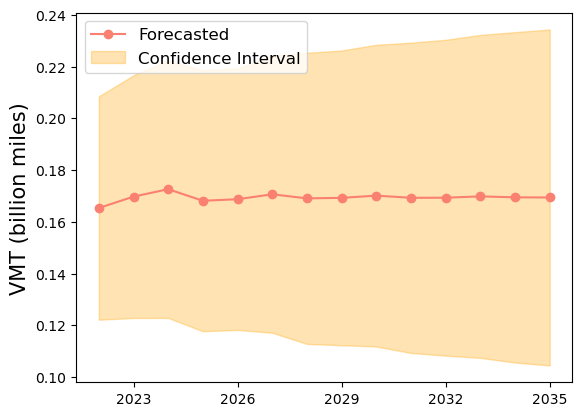

In [25]:
def arima_forecast(train, test, order,forecast_horizon,plot_file,color1,color2):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order,enforce_stationarity= False, enforce_invertibility= False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    forecast = res.forecast(steps=forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    forecast.index = range(2022, 2022 + forecast_horizon)
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')

    # Plot the confidence interval
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')

    plt.ylabel('VMT (billion miles)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3 # Change this value to set the desired interval

# Set x-ticks with the specified interval
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))

    # Save the plot
    plt.savefig(plot_file)

    return res,forecast,confidence_interval


HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
HEM_data = df['Hartford (MMTCO2e)']
plot_file = '../../../figures/hartford-forecast-emissions-agriculture.png'  # File to save the plot

HEM_summary,HEM_forecast,HEM_confidence_interval=arima_forecast(HEM_data, HEM_test,(4,1,3),14, plot_file,'salmon','orange')
HEM_summary.summary()

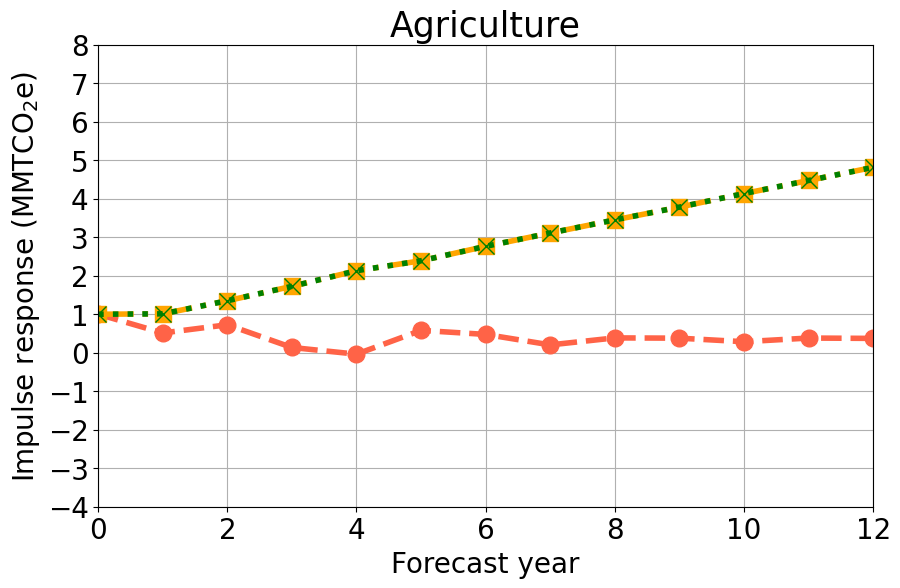

In [26]:
import matplotlib.pyplot as plt

def arima_forecast_1(train, order, forecast_horizon, plot_file, color1, color2):
    # Fit the ARIMA model with the specified order
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    res = mod.fit()
    
    # Forecasting
    forecast = res.forecast(steps=forecast_horizon)
    forecast.index = range(2023, 2023 + forecast_horizon)

    # Calculate the confidence interval
    forecast_object = res.get_forecast(steps=forecast_horizon)
    confidence_interval = forecast_object.conf_int()

    # Plot the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(forecast.index, forecast, marker='o', color=color1, label='Forecasted')
    plt.fill_between(forecast.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color=color2, alpha=0.3, label='Confidence Interval')
    plt.ylabel('VMT (billion miles)', fontsize=15)
    plt.legend(fontsize=12, loc='upper left')

    # Define the interval between x-ticks
    x_tick_interval = 3
    plt.xticks(range(2023, 2023 + forecast_horizon, x_tick_interval))
    
    # Save the forecast plot
    plt.savefig(plot_file)
    plt.close()
    
    # Impulse Response Calculation
    impulse_responses = res.impulse_responses(steps=forecast_horizon, impulse=0, orthogonalized=False, cumulative=False, anchor='end')
    
    # Ensure the length of impulse_responses matches the forecast_horizon
    impulse_responses = impulse_responses[:forecast_horizon]
    
    return res, forecast, confidence_interval, impulse_responses

def plot_multiple_irfs(irf_data, forecast_horizon, start_year, plot_file):
    plt.figure(figsize=(10, 6))
    
    for region, irf in irf_data.items():
        plt.plot(
            range(0, forecast_horizon),
            irf['impulse_responses'],
            marker=irf.get('marker', 'o'),  # default marker if 'marker' key is missing
            label=f'{region}',
            color=irf.get('color', None),  # default color if 'color' key is missing
            linestyle=irf.get('linestyle', '-'),  # default linestyle if 'linestyle' key is missing
            linewidth=irf.get('linewidth', 2),  # default linewidth if 'linewidth' key is missing
            alpha=irf.get('alpha', 0.7),  # default alpha if 'alpha' key is missing
            markersize=irf.get('markersize', 6)  # default markersize if 'markersize' key is missing
        )
    
    #plt.xlabel('Year', fontsize=20)
    plt.ylabel('Impulse response (MMTCO$_2$e)', fontsize=20)
    plt.xlabel('Forecast year', fontsize=20)
    #plt.legend(fontsize=12)
    plt.title('Agriculture', fontsize=25)
    plt.grid(True)
    
     # Set x-ticks to display years from the start year
    plt.xticks(range(0, forecast_horizon, 2))
    plt.xticks(fontsize=20)
    
    plt.xticks(fontsize=20) 
    # Set y-ticks to be integers
    max_y = 8  # Replace with your actual maximum value if different
    plt.yticks(range(-4, max_y + 1))
    
    plt.ylim(-4, 8)
    plt.yticks(fontsize=20)
    
    # Adjust the spacing and save the plot
    plt.margins(x=0, y=0)
    plt.savefig(plot_file, dpi=600, bbox_inches='tight')

# Assuming df is your DataFrame and it contains columns for each region
regions = {
    'Hartford': {
        'data': df['Hartford (MMTCO2e)'],
        'order': (4, 1,3),
        'color': 'tomato',
        'marker': 'o',
        'linestyle': '--',
        'linewidth': 4,
        'alpha': 1,
        'markersize': 12
    },
    'New Haven': {
        'data': df['New Haven (MMTCO2e)'],
        'order': (3,2,0),
        'color': 'orange',
        'marker': 's',
        'linestyle': '-.',
        'linewidth': 4,
        'alpha': 1,
        'markersize': 12
    },
    'Bridgeport': {
        'data': df['Bridgeport (MMTCO2e)'],
        'order': (3,2,0),
        'color': 'green', 
        'marker': 'x',
        'linestyle': ':',
        'linewidth': 4,
        'alpha': 1,
        'markersize': 12
    }
}


forecast_horizon = 13
start_year = 2023
irf_data = {}

for region, params in regions.items():
    plot_file = f'../../../figures/{region.lower().replace(" ", "")}-forecast-vmt.png'
    summary, forecast, confidence_interval, impulse_responses = arima_forecast_1(params['data'], params['order'], forecast_horizon, plot_file, params['color'], params['color'])
    irf_data[region] = {
        'impulse_responses': impulse_responses,
        'color': params['color'],
        'marker': params['marker'],  # Adding marker information
        'linestyle': params['linestyle'],  # Adding linestyle information
        'linewidth': params['linewidth'],  # Adding linewidth information
        'alpha': params['alpha'],  # Adding alpha information
        'markersize': params['markersize']
    }

# Plot all impulse response functions together
irf_plot_file = '../../../figures/impulse-function/agriculture-IRF.jpg'
plot_multiple_irfs(irf_data, forecast_horizon, start_year, irf_plot_file)


In [27]:
def arima_test_data_performance_metrics(train, test, order):
    # Fit the SARIMA model with the optimal parameters
    mod = sm.tsa.arima.ARIMA(train, order=order, enforce_stationarity=False, enforce_invertibility=False, concentrate_scale=False)
    #what are existing forecasting, few slides 
    res = mod.fit()

    test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    test_forecast_mean = test_forecast.predicted_mean

    new_index = range(2023-len(test),2023)
    test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Emissions (MMTCO2e)'])
    test_forecast_df['Year'] = new_index


    # Set the 'Year' column as the index
    test_forecast_df.set_index('Year', inplace=True)
    
    test_forecast_df.index = pd.to_datetime(test_forecast_df.index, format='%Y')


    actual_values = test
    predicted_values = test_forecast_df['Emissions (MMTCO2e)']

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    bic = res.bic

    return mae, rmse, mape, bic

HEM_train = df_train['Hartford (MMTCO2e)']
HEM_test = df_test['Hartford (MMTCO2e)']
mae, rmse, mape, bic = arima_test_data_performance_metrics(HEM_train, HEM_test,(4,1,3))
print(mae)
print(rmse)
print(mape)
print(bic)

0.0037407502104699203
0.004722273873824007
1.292491042779111
-68.78800731503046


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     New Haven (MMTCO2e)   No. Observations:                   32
Model:                  ARIMA(3, 2, 0)   Log Likelihood                 102.295
Date:                 Mon, 01 Jul 2024   AIC                           -196.589
Time:                         13:56:39   BIC                           -191.406
Sample:                     01-01-1990   HQIC                          -195.048
                          - 01-01-2021                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9900      0.211     -4.696      0.000      -1.403      -0.577
ar.L2         -0.6499      0.296     -2.199      0.028      -1.229      -0.071
ar.L3         -0.2827      0.303     -0.933      0.351      -0.877       0.311
sigma2      2.997e-05    7.5e-06      3.994      0.000    1.53e-05    4.47e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 6.84
Prob(Q):                              0.55   Prob(JB):                         0.03
Heteroskedasticity (H):               0.67   Skew:                             0.41
Prob(H) (two-sided):                  0.55   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

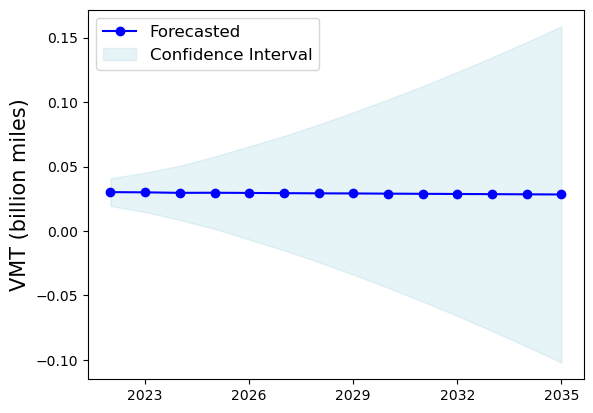

In [28]:
NHM_train = df_train['New Haven (MMTCO2e)']
NHM_test = df_test['New Haven (MMTCO2e)']
NHM_data = df['New Haven (MMTCO2e)']
plot_file = '../../../figures/newhaven-forecast-emissions-agriculture.png'  # File to save the plot

summary, NHM_forecast,NHM_confidence_interval=arima_forecast(NHM_data, NHM_test, (3,2,0),14, plot_file,'blue','lightblue')
summary.summary()

In [29]:
NHM_train = df_train['New Haven (MMTCO2e)']
NHM_test = df_test['New Haven (MMTCO2e)']
mae, rmse, mape, bic= arima_test_data_performance_metrics(NHM_train, NHM_test,(3,2,0))
print(mae, rmse, mape, bic)

0.006443696045111265 0.00665731339915633 20.72466116918999 -142.33050097468714


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Bridgeport (MMTCO2e)   No. Observations:                   32
Model:                   ARIMA(3, 2, 0)   Log Likelihood                 122.238
Date:                  Mon, 01 Jul 2024   AIC                           -236.476
Time:                          13:56:39   BIC                           -231.293
Sample:                      01-01-1990   HQIC                          -234.935
                           - 01-01-2021                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9900      0.211     -4.698      0.000      -1.403      -0.577
ar.L2         -0.6499      0.295     -2.200      0.028      -1.229      -0.071
ar.L3         -0.2827      0.303     -0.933      0.351      -0.877       0.311
sigma2      6.837e-06   1.71e-06      3.996      0.000    3.48e-06    1.02e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 6.84
Prob(Q):                              0.55   Prob(JB):                         0.03
Heteroskedasticity (H):               0.67   Skew:                             0.41
Prob(H) (two-sided):                  0.55   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

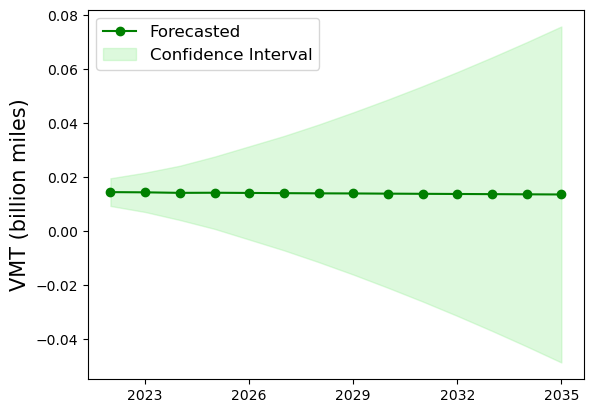

In [30]:
BSN_train = df_train['Bridgeport (MMTCO2e)']
BSN_test = df_test['Bridgeport (MMTCO2e)']
BSN_data = df['Bridgeport (MMTCO2e)']
plot_file = '../../../figures/bridgeport-forecast-emissions-agriculture.png'  # File to save the plot

summary, BSN_forecast,BSN_confidence_interval=arima_forecast(BSN_data, BSN_test,(3,2,0),14, plot_file,'green','lightgreen')#chagne the function name. make function shorter; call old function in new function
summary.summary()

In [31]:
mae, rmse, mape,bic = arima_test_data_performance_metrics(BSN_train, BSN_test,(3,2,0))
print(mae,rmse, mape,bic)

0.003078562557478809 0.003180621131324294 20.72467031339536 -173.35337962246288


In [32]:
def test_train_fitting_VMT(train,order):
    # Forecast on training data
    mod = sm.tsa.arima.ARIMA(train, order=order)
    res = mod.fit()
    
    train_forecast = res.get_prediction(start=0, end=len(train)-1)
    train_forecast_mean = train_forecast.predicted_mean.iloc[1:]
    train_conf_int = train_forecast.conf_int().iloc[1:]

    #test_forecast = res.get_prediction(start=len(train), end=len(train)+len(test)-1)
    #test_forecast_mean = test_forecast.predicted_mean
    #test_conf_int = test_forecast.conf_int()
    
    return train_forecast_mean,train_conf_int
    

emissions_train_HEM,train_conf_int_HEM=test_train_fitting_VMT(HEM_data,(4,1,3))
emissions_train_NHM,train_conf_int_NHM=test_train_fitting_VMT(NHM_data,(3,2,0))
emissions_train_BSN,train_conf_int_BSN=test_train_fitting_VMT(BSN_data,(3,2,0))
    

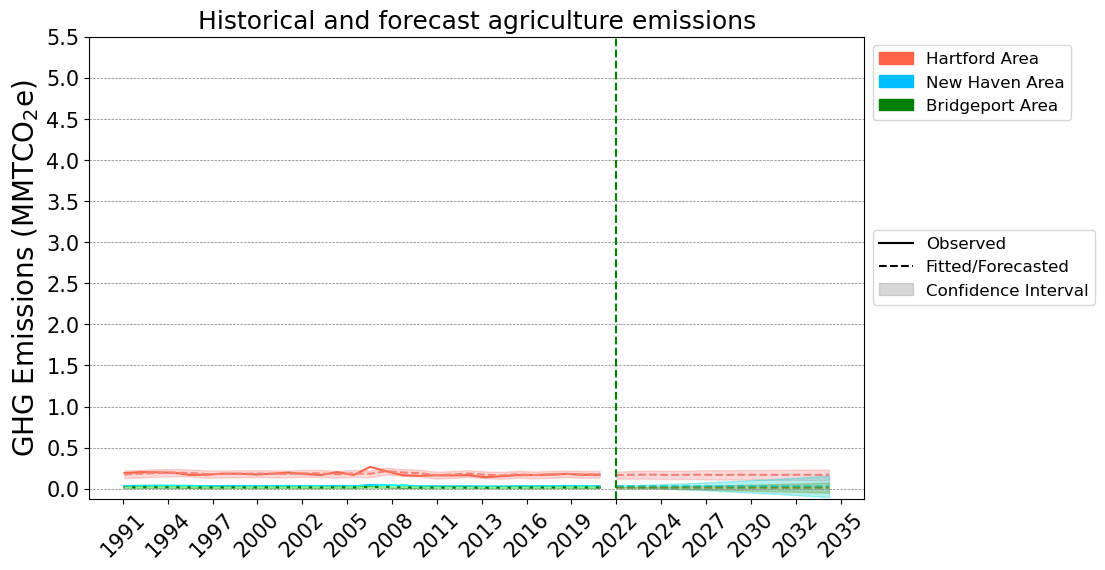

In [33]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([HEM_train,HEM_test])[2:]
concatenated_predicted_HEM = emissions_train_HEM[1:]
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato')
plt.plot(concatenated_predicted_HEM.index, concatenated_predicted_HEM, label='Hartford_Fitted', color='salmon', linestyle='--')

plt.plot(HEM_forecast.index, HEM_forecast, color='lightcoral', label='Hartford_Forecasted',linestyle='--')
plt.fill_between(HEM_forecast.index, HEM_confidence_interval.iloc[:, 0], HEM_confidence_interval.iloc[:, 1], color='lightcoral', alpha=0.3)
plt.fill_between(emissions_train_HEM[1:].index, train_conf_int_HEM.iloc[1:, 0], train_conf_int_HEM.iloc[1:, 1], color='lightcoral', alpha=0.3)


concatenated_observed_NHM = pd.concat([NHM_train,NHM_test])[2:]
concatenated_predicted_NHM = emissions_train_NHM[1:]
NHM_forecast.index = pd.to_datetime(NHM_forecast.index, format='%Y')
plt.plot(concatenated_observed_NHM.index, concatenated_observed_NHM,label='New Haven_Observed', color='deepskyblue')
plt.plot(concatenated_predicted_NHM.index, concatenated_predicted_NHM, label='New Haven_Fitted', color='cyan', linestyle='--')

plt.plot(NHM_forecast.index, NHM_forecast, color='darkturquoise', label='New Haven_Forecasted',linestyle='--')
plt.fill_between(NHM_forecast.index, NHM_confidence_interval.iloc[:, 0], NHM_confidence_interval.iloc[:, 1], color='darkturquoise', alpha=0.3)
plt.fill_between(emissions_train_NHM[1:].index, train_conf_int_NHM.iloc[1:, 0], train_conf_int_NHM.iloc[1:, 1], color='darkturquoise', alpha=0.3)

concatenated_observed_BSN = pd.concat([BSN_train,BSN_test])[2:]
concatenated_predicted_BSN = emissions_train_BSN[1:]
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
plt.plot(concatenated_observed_BSN.index, concatenated_observed_BSN,label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_BSN.index, concatenated_predicted_BSN, label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

plt.plot(BSN_forecast.index, BSN_forecast, color='olivedrab', label='Bridgeport_Forecasted',linestyle='--')
plt.fill_between(BSN_forecast.index, BSN_confidence_interval.iloc[:, 0], BSN_confidence_interval.iloc[:, 1], color='olivedrab', alpha=0.3)
plt.fill_between(emissions_train_BSN[1:].index, train_conf_int_BSN.iloc[1:, 0], train_conf_int_BSN.iloc[1:, 1], color='olivedrab', alpha=0.3)


# Legend for Colors (Locations)
tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
deepskyblue_patch = mpatches.Patch(color='deepskyblue', label='New Haven Area')
green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
color_legend = plt.legend(handles=[tomato_patch, deepskyblue_patch, green_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add the first legend manually to the plot
plt.gca().add_artist(color_legend)

# Legend for Patterns (Data Types)
solid_line = mlines.Line2D([], [], color='black', label='Observed')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Historical and forecast agriculture emissions', fontsize=18)
plt.ylabel('GHG Emissions (MMTCO$_2$e)', fontsize=20)

plt.xticks(fontsize=15, rotation=45) 
plt.yticks(fontsize=15)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2022, 1, 1), color='green', linestyle='--', label='Year 2022 (X-axis)')

# Hide the grid lines behind the line plot
plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5, zorder=1)


max_y_value = 6
plt.yticks(np.arange(0, max_y_value, 0.5))


plt.savefig('../../../figures/forecast/agriculture_forecast.png', dpi=600, bbox_inches='tight')

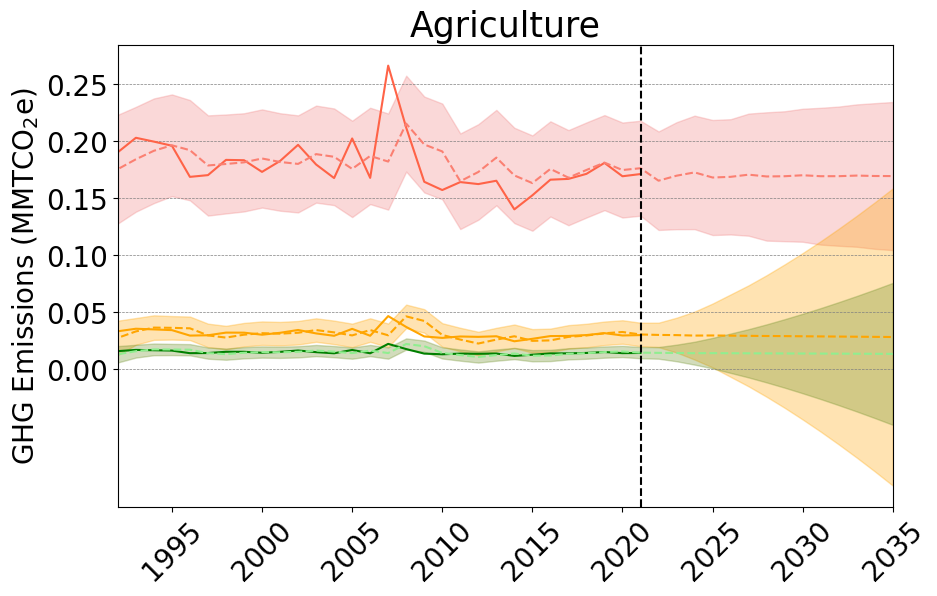

In [46]:
plt.figure(figsize=(10, 6))


concatenated_observed_HEM = pd.concat([HEM_train,HEM_test])[1:]
HEM_forecast.index = pd.to_datetime(HEM_forecast.index, format='%Y')
concatenated_predicted_forecast_HEM = pd.concat([emissions_train_HEM,HEM_forecast])

#plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato')
#plt.plot(concatenated_predicted_forecast_HEM.index, concatenated_predicted_forecast_HEM, label='Hartford_Fitted', color='salmon', linestyle='--')

concatenated_confidence_interval_HEM = pd.concat([train_conf_int_HEM, HEM_confidence_interval])
#plt.fill_between(concatenated_confidence_interval_HEM[1:].index, concatenated_confidence_interval_HEM.iloc[1:, 0], concatenated_confidence_interval_HEM.iloc[1:, 1], color='lightcoral', alpha=0.3)


plt.fill_between(concatenated_confidence_interval_HEM[1:].index, concatenated_confidence_interval_HEM.iloc[1:, 0], concatenated_confidence_interval_HEM.iloc[1:, 1], color='lightcoral', alpha=0.3, clip_on=True)

plt.plot(concatenated_observed_HEM.index, concatenated_observed_HEM,label='Hartford_Observed', color='tomato', clip_on=True)
plt.plot(concatenated_predicted_forecast_HEM.index, concatenated_predicted_forecast_HEM, label='Hartford_Fitted', color='salmon', linestyle='--', clip_on=True)


concatenated_observed_NHM = pd.concat([NHM_train,NHM_test])[1:]
NHM_forecast.index = pd.to_datetime(NHM_forecast.index, format='%Y')
concatenated_predicted_forecast_NHM = pd.concat([emissions_train_NHM,NHM_forecast])

plt.plot(concatenated_observed_NHM.index, concatenated_observed_NHM,label='New Haven_Observed', color='orange')
plt.plot(concatenated_predicted_forecast_NHM.index, concatenated_predicted_forecast_NHM, label='New Haven_Fitted', color='orange', linestyle='--')

concatenated_confidence_interval_NHM = pd.concat([train_conf_int_NHM, NHM_confidence_interval])
plt.fill_between(concatenated_confidence_interval_NHM[1:].index, concatenated_confidence_interval_NHM.iloc[1:, 0], concatenated_confidence_interval_NHM.iloc[1:, 1], color='orange', alpha=0.3)


concatenated_observed_BSN = pd.concat([BSN_train,BSN_test])[1:]
BSN_forecast.index = pd.to_datetime(BSN_forecast.index, format='%Y')
concatenated_predicted_forecast_BSN = pd.concat([emissions_train_BSN,BSN_forecast])

plt.plot(concatenated_observed_BSN.index, concatenated_observed_BSN,label='Bridgeport_Observed', color='green')
plt.plot(concatenated_predicted_forecast_BSN.index, concatenated_predicted_forecast_BSN, label='Bridgeport_Fitted', color='lightgreen', linestyle='--')

concatenated_confidence_interval_BSN = pd.concat([train_conf_int_BSN, BSN_confidence_interval])
plt.fill_between(concatenated_confidence_interval_BSN[1:].index, concatenated_confidence_interval_BSN.iloc[1:, 0], concatenated_confidence_interval_BSN.iloc[1:, 1], color='olivedrab', alpha=0.3)


# # Legend for Colors (Locations)
# tomato_patch = mpatches.Patch(color='tomato', label='Hartford Area')
# deepskyblue_patch = mpatches.Patch(color='orange', label='New Haven Area')
# green_patch = mpatches.Patch(color='green', label='Bridgeport Area')
# color_legend = plt.legend(handles=[tomato_patch, deepskyblue_patch, green_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# # Add the first legend manually to the plot
# plt.gca().add_artist(color_legend)

# # Legend for Patterns (Data Types)
# solid_line = mlines.Line2D([], [], color='black', label='Observed')
# dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Fitted/Forecasted')
# alpha_patch = mpatches.Patch(color='grey', alpha=0.3, label='Confidence Interval')
# plt.legend(handles=[solid_line, dashed_line, alpha_patch], title="", fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.6))

# Title, labels, ticks, and other plot formatting as per your code
plt.title('Agriculture', fontsize=25)
plt.ylabel('GHG Emissions (MMTCO$_2$e)', fontsize=20)

plt.xticks(fontsize=20, rotation=45) 
plt.yticks(fontsize=20)
# Set the y-axis tick range
#plt.ylim(0, 1.5)  # Adjust the range according to your preference

# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=datetime.datetime(2021, 1, 1), color='black', linestyle='--', label='Year 2022 (X-axis)')

# Hide the grid lines behind the line plot
plt.grid(axis='y', linestyle='--', color='gray', linewidth=0.5, zorder=1)

plt.xlim(datetime.datetime(1992, 1, 1), datetime.datetime(2035, 1, 1))

max_y_value = 0.3
plt.yticks(np.arange(0, max_y_value, 0.05))


plt.savefig('../../../figures/forecast/agriculture_forecast.png', dpi=600, bbox_inches='tight')

In [47]:
concatenated_predicted_forecast_HEM.to_csv('../../../results/predictions/agriculture-emissions-prediction-HEM.csv')
concatenated_predicted_forecast_NHM.to_csv('../../../results/predictions/agriculture-emissions-prediction-NHM.csv')
concatenated_predicted_forecast_BSN.to_csv('../../../results/predictions/agriculture-emissions-prediction-BSN.csv')

In [35]:
HEM_2022 = concatenated_observed_HEM[-1]
HEM_2035 = concatenated_predicted_forecast_HEM[-1]
HEM_per = (HEM_2022-HEM_2035)/HEM_2022*100 #%

In [36]:
NHM_2022 = concatenated_observed_NHM[-1]
NHM_2035 = concatenated_predicted_forecast_NHM[-1]
NHM_per = (NHM_2022-NHM_2035)/NHM_2022*100 #%

In [37]:
BSN_2022 = concatenated_observed_BSN[-1]
BSN_2035 = concatenated_predicted_forecast_BSN[-1]
BSN_per = (BSN_2022-BSN_2035)/BSN_2022*100 #% 

In [38]:
concatenated_predicted_forecast_HEM

1991-01-01    0.183533
1992-01-01    0.175468
1993-01-01    0.184122
1994-01-01    0.191580
1995-01-01    0.196384
1996-01-01    0.192100
1997-01-01    0.178686
1998-01-01    0.180012
1999-01-01    0.181419
2000-01-01    0.184819
2001-01-01    0.181754
2002-01-01    0.180066
2003-01-01    0.188642
2004-01-01    0.186303
2005-01-01    0.175694
2006-01-01    0.187063
2007-01-01    0.182117
2008-01-01    0.215390
2009-01-01    0.197081
2010-01-01    0.191007
2011-01-01    0.164861
2012-01-01    0.172971
2013-01-01    0.185597
2014-01-01    0.169957
2015-01-01    0.163249
2016-01-01    0.175662
2017-01-01    0.167993
2018-01-01    0.174744
2019-01-01    0.181194
2020-01-01    0.174697
2021-01-01    0.176283
2022-01-01    0.165338
2023-01-01    0.169726
2024-01-01    0.172614
2025-01-01    0.168135
2026-01-01    0.168733
2027-01-01    0.170635
2028-01-01    0.169058
2029-01-01    0.169264
2030-01-01    0.170119
2031-01-01    0.169278
2032-01-01    0.169312
2033-01-01    0.169833
2034-01-01 

In [39]:
concatenated_predicted_forecast_HEM.index = pd.to_datetime(concatenated_predicted_forecast_HEM.index)
concatenated_observed_HEM.index = pd.to_datetime(concatenated_observed_HEM.index)

# Extract data for the year 2021
HEM_2021 = concatenated_observed_HEM['2021'].values
HEM_2035 = concatenated_predicted_forecast_HEM['2035'].values


concatenated_predicted_forecast_NHM.index = pd.to_datetime(concatenated_predicted_forecast_NHM.index)
concatenated_observed_NHM.index = pd.to_datetime(concatenated_observed_NHM.index)

NHM_2021 = concatenated_observed_NHM['2021'].values
NHM_2035= concatenated_predicted_forecast_NHM['2035'].values


concatenated_predicted_forecast_BSN.index = pd.to_datetime(concatenated_predicted_forecast_BSN.index)
concatenated_observed_BSN.index = pd.to_datetime(concatenated_observed_BSN.index)

# Extract data for the year 2021
BSN_2021 = concatenated_observed_BSN['2021'].values
BSN_2035= concatenated_predicted_forecast_BSN['2035'].values


#how to calculate the difference: the difference equals the (old-new)/old
NHM_per = (NHM_2021-NHM_2035)/NHM_2021*100 #%

HEM_per = (HEM_2021-HEM_2035)/HEM_2021*100 #%

BSN_per = (BSN_2021-BSN_2035)/BSN_2021*100 #%

print(HEM_per,NHM_per,BSN_per)

[1.03484436] [5.61609287] [5.61609809]


In [40]:
df = pd.DataFrame({'Column1': -HEM_per, 'Column2': -NHM_per, 'Column3': -BSN_per})
df

,Column1,Column2,Column3
0,-1.034844,-5.616093,-5.616098


In [41]:
data = pd.DataFrame({'Column1': HEM_2021, 'Column2': HEM_2035, 'Column3': NHM_2021, 'Column4': NHM_2035, 'Column5': BSN_2021, 'Column6': BSN_2035})
data

,Column1,Column2,Column3,Column4,Column5,Column6
0,0.171178,0.169406,0.029987,0.028303,0.014327,0.013522


In [42]:
concatenated_predicted_forecast_HEM.index

DatetimeIndex(['1991-01-01', '1992-01-01', '1993-01-01', '1994-01-01',
               '1995-01-01', '1996-01-01', '1997-01-01', '1998-01-01',
               '1999-01-01', '2000-01-01', '2001-01-01', '2002-01-01',
               '2003-01-01', '2004-01-01', '2005-01-01', '2006-01-01',
               '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01',
               '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01',
               '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01',
               '2023-01-01', '2024-01-01', '2025-01-01', '2026-01-01',
               '2027-01-01', '2028-01-01', '2029-01-01', '2030-01-01',
               '2031-01-01', '2032-01-01', '2033-01-01', '2034-01-01',
               '2035-01-01'],
              dtype='datetime64[ns]', freq=None)

In [43]:
concatenated_confidence_interval_HEM['ME'] = (concatenated_confidence_interval_HEM.iloc[:, 1] - concatenated_confidence_interval_HEM.iloc[:, 0]) / 2
concatenated_confidence_interval_HEM

,lower Hartford (MMTCO2e),upper Hartford (MMTCO2e),ME
1991-01-01,0.131929,0.235136,0.051603
1992-01-01,0.127816,0.223120,0.047652
1993-01-01,0.138164,0.230080,0.045958
1994-01-01,0.145696,0.237465,0.045884
1995-01-01,0.151807,0.240961,0.044577
1996-01-01,0.148154,0.236046,0.043946
1997-01-01,0.134758,0.222614,0.043928
1998-01-01,0.136643,0.223382,0.043370
1999-01-01,0.138376,0.224462,0.043043
2000-01-01,0.141788,0.227851,0.043032


In [44]:
concatenated_confidence_interval_NHM['ME'] = (concatenated_confidence_interval_NHM.iloc[:, 1] - concatenated_confidence_interval_NHM.iloc[:, 0]) / 2
concatenated_confidence_interval_NHM

,lower New Haven (MMTCO2e),upper New Haven (MMTCO2e),ME
1991-01-01,-1385.855597,1385.952052,1385.903824
1992-01-01,0.012529,0.042604,0.015037
1993-01-01,0.021469,0.044947,0.011739
1994-01-01,0.025810,0.047306,0.010748
1995-01-01,0.026035,0.046654,0.010309
1996-01-01,0.025618,0.046236,0.010309
1997-01-01,0.019393,0.040012,0.010309
1998-01-01,0.017489,0.038108,0.010309
1999-01-01,0.020032,0.040651,0.010309
2000-01-01,0.021345,0.041963,0.010309


In [45]:
concatenated_confidence_interval_BSN['ME'] = (concatenated_confidence_interval_BSN.iloc[:, 1] - concatenated_confidence_interval_BSN.iloc[:, 0]) / 2
concatenated_confidence_interval_BSN

,lower Bridgeport (MMTCO2e),upper Bridgeport (MMTCO2e),ME
1991-01-01,-1385.880783,1385.926866,1385.903824
1992-01-01,0.005992,0.020348,0.007178
1993-01-01,0.010262,0.021469,0.005604
1994-01-01,0.012335,0.022596,0.005130
1995-01-01,0.012443,0.022285,0.004921
1996-01-01,0.012243,0.022086,0.004921
1997-01-01,0.009270,0.019112,0.004921
1998-01-01,0.008360,0.018202,0.004921
1999-01-01,0.009575,0.019417,0.004921
2000-01-01,0.010202,0.020044,0.004921
